In [1]:
import pickle
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('merged_train.pkl')
test_data = pd.read_pickle('merged_test.pkl')

In [5]:
print("*"*35)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*35)

***********************************

 Train Data Shape : (590540, 434) 


 Test Data Shape : (506691, 433) 

***********************************


### Utility Functions
<br>

In [6]:
def cat_num_features(df):
    
    '''
        Utility Function to get the names of Categorical Features and 
        Numerical Features of the given Dataset.
    '''
    
    catf = []
    numf = []
    
    # Given Categorical Features 
    catf = ['ProductCD', 
            'card1', 'card2', 'card3', 'card4', 'card5','card6', 
            'addr1', 'addr2', 
            'P_emaildomain', 'R_emaildomain', 
            'M1', 'M2','M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
            'DeviceType', 'DeviceInfo'
           ]
    catf+=['id_'+str(i) for i in range(12,39)]


    # Updating the Categorical Feature Names List based on the columns present in the dataframe
    catf = [feature for feature in catf if feature in df.columns.values]
    numf = [feature for feature in df.columns if feature not in catf and not feature == 'isFraud']
    
    return (catf, numf)  

In [7]:
def label_encode(X_train, X_cv, catf):
  
  '''
    Utility Function to Encode Categorical Features.
  '''

  for f in catf:
    
    X_train[f] = X_train[f].astype(str)
    X_cv[f] = X_cv[f].astype(str)
    
    le = LabelEncoder()
    le.fit(X_train[f])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_train[f] = le.transform(X_train[f])
    
    # Manually Encoding the CV and Test Dataset so as to avoid error for any category which is not present in train set
    
    # All the categories which are not present in train datset are encoded as -1    
    X_cv[f] = [-1 if mapping.get(v, -1)==-1 else mapping[v] for v in X_cv[f].values ]

  return (X_train, X_cv)

In [8]:
def compute_vif(df, features):
    
    '''
        Utility Function to compute Variance Inflation Factor for given features in a dataframe.
    '''
    
    data = df[features]
    vif = {column:variance_inflation_factor(data.values, idx) for idx, column in enumerate(features)}
    return vif

In [9]:
def remove_feature_based_on_vif(train_df, vif_dict):
    
    '''
        Utility Function to remove the feature based on vif value from train and test set and return 
        the updated list of features among which VIF is being computed.
        
        Those features which have the vif value >= 10 will be continuosly 
        removed one by one until no such feature is left.  
    '''

    features_to_be_discarded = []

    train = copy.deepcopy(train_df)
    rf = max(vif_dict, key=vif_dict.get) # Getting the feature with max vif value
    thr = vif_dict[rf] # Storing the vif value of that feature
    
    # Checking if the largest vif value if greater than or equal to 10
    while(thr>=10):
        features_to_be_discarded.append(rf) 
        vif_dict.pop(rf) # Removing the feature and its vif value from the vif dictionary
        features = list(vif_dict.keys()) # Updated list of features
        train = train_df.drop(columns=rf, axis=1) # Removing the feature from train dataset
        if(len(features)==1):
            break # break if only one feature remains 
        
        vif_dict = compute_vif(train, features) # Recomputing the VIF values
        rf = max(vif_dict, key=vif_dict.get) 
        thr = vif_dict[rf]
      
    del train
        
        
    return features_to_be_discarded

In [10]:
def backward_feature_selection(train_df, features):

  '''
    Utility Function to perform Recusrive Feature Elimination.
  '''

  X = train_df.drop(['isFraud', 'TransactionID'], axis=1)
  y = train_df['isFraud']

  X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=3)
  del X,y

  # Imputing the missing values of Categorical Columns with "missing"

  X_train[catf] = X_train[catf].fillna('missing')
  X_cv[catf] = X_cv[catf].fillna('missing')


  # Label Encoding Categorical Features

  X_train, X_cv = label_encode(X_train, X_cv, catf)


  clf = XGBClassifier(
      objective='binary:logistic',
      eval_metric='auc',
      n_estimators=3000,
      tree_method='gpu_hist',
      random_state=3,
      subsample=0.8,
      max_depth=12,
      colsample_bytree=0.6,
      learning_rate=0.02
  )

  clf.fit(X_train, y_train, eval_set=[(X_cv, y_cv)], verbose=100, early_stopping_rounds=200)
  

  best_cv_auc = roc_auc_score(y_cv, clf.predict_proba(X_cv)[:,1])
  current_cv_auc = 0

  print("Current Cross Validation AUC is {}\n\n".format(best_cv_auc))

  features_to_be_discarded = []

  for f in features:

    if(f not in X_train.columns):
      continue
    
    drop_f_train = X_train[f]
    drop_f_cv = X_cv[f]

    X_train.drop(f, axis=1, inplace=True)
    X_cv.drop(f, axis=1, inplace=True)

    clf.fit(X_train, y_train, eval_set=[(X_cv, y_cv)], verbose=100, early_stopping_rounds=200)

    current_cv_auc = roc_auc_score(y_cv, clf.predict_proba(X_cv)[:,1])

    if(current_cv_auc>best_cv_auc):
      print("Cross Validation AUC increased from {} to {} on removing {}".format(best_cv_auc, current_cv_auc, f))
      print("REMOVING FEATURE {}\n\n".format(f))
      features_to_be_discarded.append(f)
      best_cv_auc = current_cv_auc

    elif(current_cv_auc==best_cv_auc):

      print("Cross Validation AUC did not change.")
      print("REMOVING FEATURE {}\n\n".format(f))
      features_to_be_discarded.append(f)
    
    else:
      print("Cross Validation AUC decreased from {} to {} on removing {}".format(best_cv_auc, current_cv_auc, f))
      print("NOT REMOVING FEATURE {}\n\n".format(f))
      X_train[f] = drop_f_train
      X_cv[f] = drop_f_cv

  return features_to_be_discarded

In [11]:
def is_consistent_over_time(train_df, f):
  
  '''
  Utility Function to check for consistency over time of a feature
  '''

  train = train_df[:int(0.2*len(train_df))] # Using the first 20%
  cv = train_df[int(0.8*len(train_df)):]  # To predict the last 20%

  X_train = train.drop('isFraud', axis=1)[[f]]
  y_train = train['isFraud']

  X_cv = cv.drop('isFraud', axis=1)[[f]]
  y_cv = cv['isFraud']

  del train, cv

  if(X_train[f].dtype == 'object'):
    X_train, X_cv = label_encode(X_train, X_cv, [f])

  clf = XGBClassifier(
      objective='binary:logistic',
      eval_metric='auc',
      n_estimators=500,
      tree_method='gpu_hist',
      random_state=3,
  )

  clf.fit(X_train, y_train, verbose=1)

  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  cv_auc = roc_auc_score(y_cv, clf.predict_proba(X_cv)[:,1])

  del X_train, y_train, X_cv, y_cv

  return (train_auc, cv_auc)

In [12]:
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id

def reduce_group(grps):
    global train_data
    chosen = []
    for parent, children in grps.items():
      max_unique = train_data[parent].nunique(); max_unique_child = parent
      for child in children:
        n = train_data[child].nunique()
        if n>max_unique:
            max_unique = n
            max_unique_child = child
      chosen.append(max_unique_child)

    print('Use these', chosen)

    return chosen

# Data Cleaning
<br>

In [13]:
# Storing Categorical and Numerical Feature Names 

catf, numf = cat_num_features(train_data)
categorical_feature_indices = [train_data.columns.get_loc(f) for f in catf]

## Removing Redundant Features
<br>

We will be removing those features,

- Which have more than 90% missing values.
- Which have constant values for all its rows.
- Which have more than 90% values the same.

In [14]:
high_null_features_train = [f for f in train_data.columns if train_data[f].isna().sum()/len(train_data) > 0.9]
high_null_features_test = [f for f in test_data.columns if test_data[f].isna().sum()/len(test_data) > 0.9]

one_value_features_train = [f for f in train_data.columns if train_data[f].nunique()<=1]
one_value_features_test = [f for f in test_data.columns if test_data[f].nunique()<=1]

constant_value_features_train = [f for f in train_data.columns if train_data[f].value_counts(dropna=False, normalize=True).values[0] > 0.9]
constant_value_features_test = [f for f in test_data.columns if test_data[f].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [15]:
drop_cols = list(set(high_null_features_train+high_null_features_test+\
                     one_value_features_train+one_value_features_test+\
                     constant_value_features_train+constant_value_features_test))

if 'isFraud' in drop_cols:
  drop_cols.remove('isFraud')

train_data.drop(drop_cols, axis=1, inplace=True)
test_data.drop(drop_cols, axis=1, inplace=True)

In [16]:
# Storing the updated Categorical and Numerical Feature Names 

catf, numf = cat_num_features(train_data)
categorical_feature_indices = [train_data.columns.get_loc(f) for f in catf]

Normally, we would have removed features having atlest 60-70% missing values, but in this challenge our objective is to detect anomalies and columns with missing values are often a great source of information. Also, the dataset given to us has very less anomalous data points and hence further removing features will further reduce the amount of information that can be gained from the dataset.
<br><br>

## Removing Collinear Features
<br>

> __C_features__

In [17]:
c_features = ["C"+str(i) for i in range(1,15) if "C"+str(i) in train_data.columns]

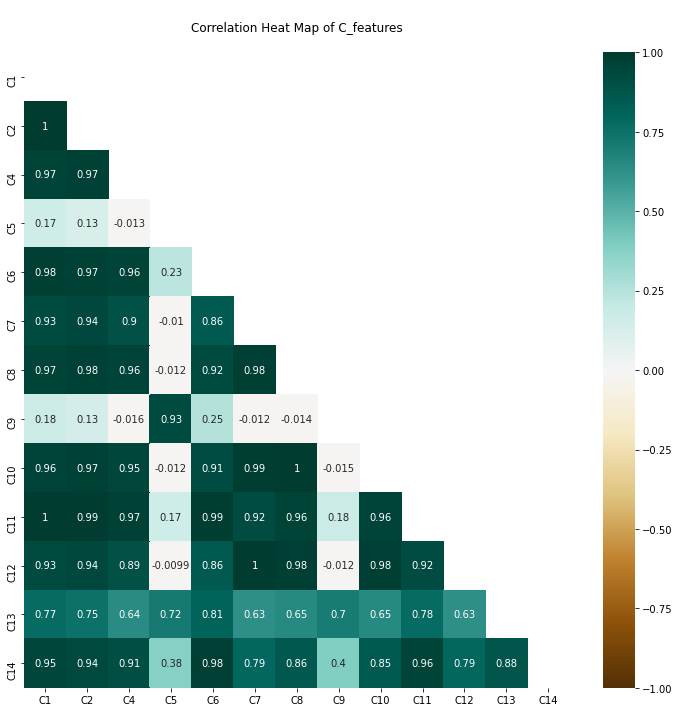

In [18]:
# Reference : https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

plt.figure(figsize=(10,10))
mask = np.triu(np.ones_like(train_data[c_features].corr(), dtype=np.bool))
sns.color_palette("crest", as_cmap=True)
sns.heatmap(train_data[c_features].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG');
plt.title('\nCorrelation Heat Map of C_features\n')
plt.tight_layout()
plt.show()

__Observation(s):__

Following Inferences can be made from the above plot,

1. Many of the C_features seem to be correlated and hence there is a high possiblity of collinearity. Now, let's compute the Variance Inflation Factor for each of the C_features to be sure about the Collinearity.
<br><br>

In [19]:
# Checking for Multicollinearity amongst the C features

vif = compute_vif(train_data, c_features)
print('\nVIF values for C_features : \n')
vif


VIF values for C_features : 



{'C1': 513.234806859085,
 'C10': 530.443901392685,
 'C11': 2313.7967581714456,
 'C12': 4195.031639777527,
 'C13': 41.238699308643724,
 'C14': 368.1435941578214,
 'C2': 347.20469829067554,
 'C4': 855.9035578856174,
 'C5': 15.058227932815006,
 'C6': 650.1293976176325,
 'C7': 2953.0231773034816,
 'C8': 1613.6199152822524,
 'C9': 69.35624181204241}

__Observation(s):__ 

Based on the VIF values many of the C_feature seem to be collinear, but we will not be removing them directly just based on the high VIF values because removing a feature migh degrade the performance of the model since all the C_features have no missing values and though they are intercorrelated but seem to hold a good amounf of information.

Hence, we will using Backward Feature Selection to test the impact of removal of each of the collinear C_features one by one. If model degrades on the removal of any feature then we won't be removing that feature.
<br><br>

In [20]:
#removing feature with high vif value

c_features_to_be_discarded = remove_feature_based_on_vif(train_data, vif)

In [21]:
# Based on the VIF analysis following c_features can be removed

c_features_to_be_discarded

['C12', 'C11', 'C8', 'C4', 'C10', 'C6', 'C1', 'C2', 'C13']

In [22]:
# Performing Backward Feature Elimination

final_c_features_to_be_discarded = backward_feature_selection(train_data, c_features_to_be_discarded)

[0]	validation_0-auc:0.853341
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.90792
[200]	validation_0-auc:0.934858
[300]	validation_0-auc:0.954015
[400]	validation_0-auc:0.960947
[500]	validation_0-auc:0.964712
[600]	validation_0-auc:0.966946
[700]	validation_0-auc:0.968674
[800]	validation_0-auc:0.96973
[900]	validation_0-auc:0.970726
[1000]	validation_0-auc:0.971607
[1100]	validation_0-auc:0.972336
[1200]	validation_0-auc:0.972886
[1300]	validation_0-auc:0.97327
[1400]	validation_0-auc:0.973502
[1500]	validation_0-auc:0.973767
[1600]	validation_0-auc:0.974068
[1700]	validation_0-auc:0.974191
[1800]	validation_0-auc:0.97437
[1900]	validation_0-auc:0.974529
[2000]	validation_0-auc:0.974672
[2100]	validation_0-auc:0.974686
[2200]	validation_0-auc:0.974774
[2300]	validation_0-auc:0.974912
[2400]	validation_0-auc:0.974949
[2500]	validation_0-auc:0.974947
[2600]	validation_0-auc:0.974917
[2700]	validation_0-auc:0.974927
[2800]	validation_0-auc:0.9

In [23]:
train_data.drop(final_c_features_to_be_discarded, axis=1, inplace=True)
test_data.drop(final_c_features_to_be_discarded, axis=1, inplace=True)

> __D_features__

In [24]:
d_features = ["D"+str(i) for i in range(1,16) if "D"+str(i) in train_data.columns]

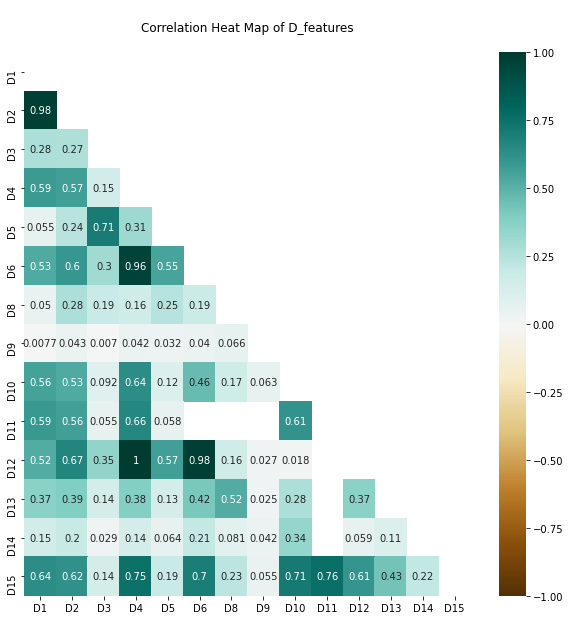

In [25]:
# Reference : https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

mask = np.triu(np.ones_like(train_data[d_features].corr(), dtype=np.bool))
plt.figure(figsize=(10,10))
sns.color_palette("crest", as_cmap=True)
sns.heatmap(train_data[d_features].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG');
plt.title('\nCorrelation Heat Map of D_features\n')
plt.show()

__Observation(s):__

Following Inferences can be made from the above plot,

1. Only three D_features seem to be correlated. We won't be removing these from the dataset, since D_features corresponds to timedelta from the previous transactions and hence can be used to identify card holder's identity.
<br><br>

> __id01-id11__

In [26]:
id_num_features = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11']
id_num_features = [f for f in id_num_features if f in train_data.columns]

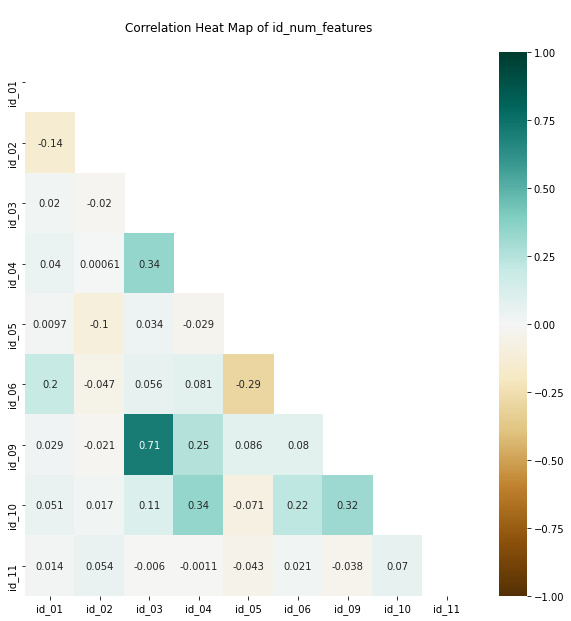

In [27]:
# Reference : https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

mask = np.triu(np.ones_like(train_data[id_num_features].corr(), dtype=np.bool))
plt.figure(figsize=(10,10))
sns.color_palette("crest", as_cmap=True)
sns.heatmap(train_data[id_num_features].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG');
plt.title('\nCorrelation Heat Map of id_num_features\n')
plt.show()

__Observation(s):__

Following Inferences can be made from the above plot,

1. No id_num_deature feature seem to have be highly inter correlated. 
<br><br>

> __V_features__

The largest number of features that we have in our dataset are the V_features and also have a large number of missing values. While performing EDA, a nice pattern between many V_features was seen, there were groups of V_features seen which were having same number of missing values. Let's explore this characterstic in depth and see if we can get some relevant information.
<br><br>

In [28]:
v_features = ["V"+str(i) for i in range(1,340) if "V"+str(i) in train_data.columns]

In [29]:
# Based on the EDA V_features can be divided into groups with same number of missig values.

v_grps = {}

for key, val in train_data[v_features].isna().sum().items():
  if(v_grps.get(val, -1)==-1):
    v_grps[val] = [key]
  else:
    v_grps[val].append(key) 

In [30]:
# V_feature groups based on same number of missing values

print("\n\nMissing Values Count    ->    Corresponding Group\n\n")
for missing_count, grp in v_grps.items():
  print(missing_count, "->", grp, "\n\n")



Missing Values Count    ->    Corresponding Group


279287 -> ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11'] 


76073 -> ['V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34'] 


168969 -> ['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52'] 


77096 -> ['V53', 'V54', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74'] 


89164 -> ['V75', 'V76', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92', 'V93', 'V94'] 


314 -> ['V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131'] 


508595 -> ['V138', 'V139', 'V140', 'V141', 'V142', 'V146', 'V147', 'V148', 'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V161', 'V162', 'V163'] 


508589 -> ['V143', 'V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160', 'V164', 'V165', 'V166'

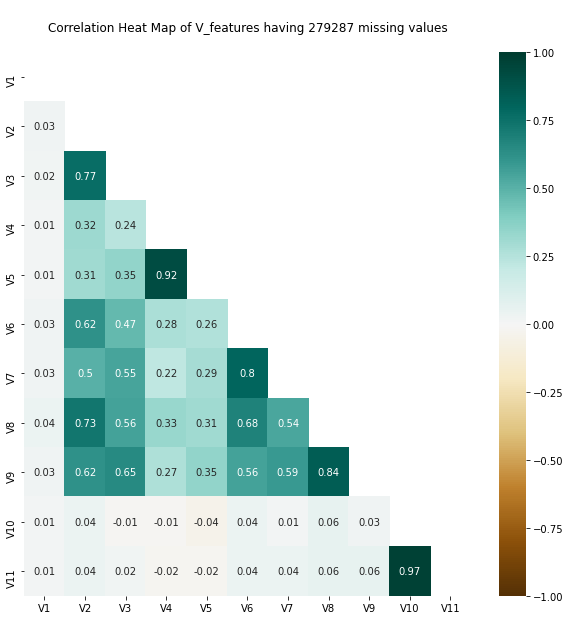

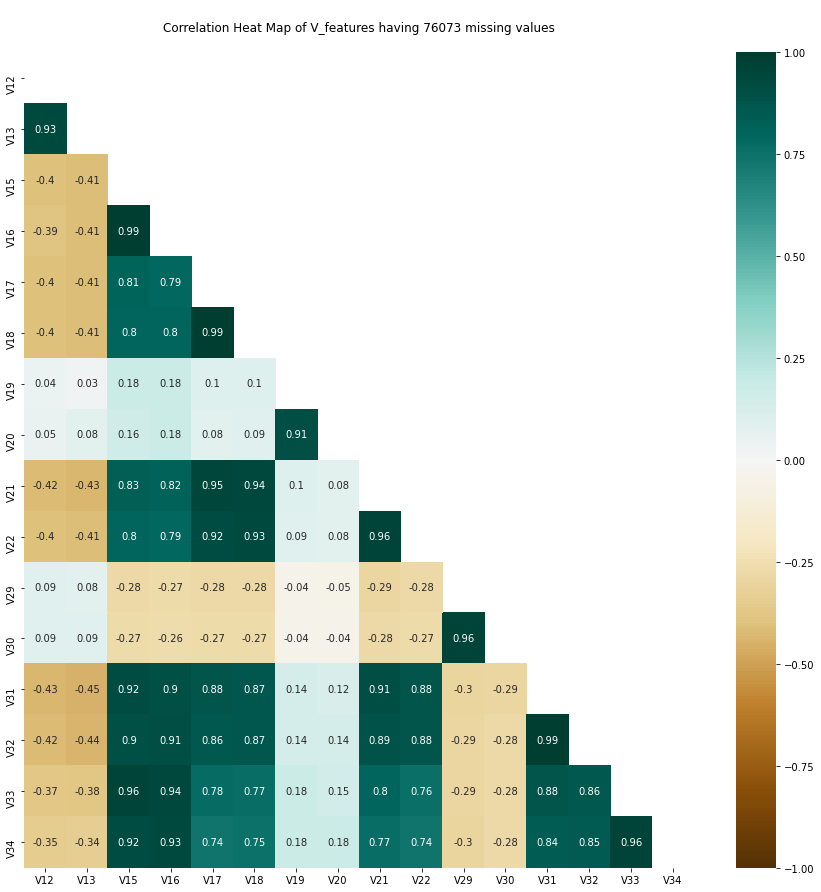

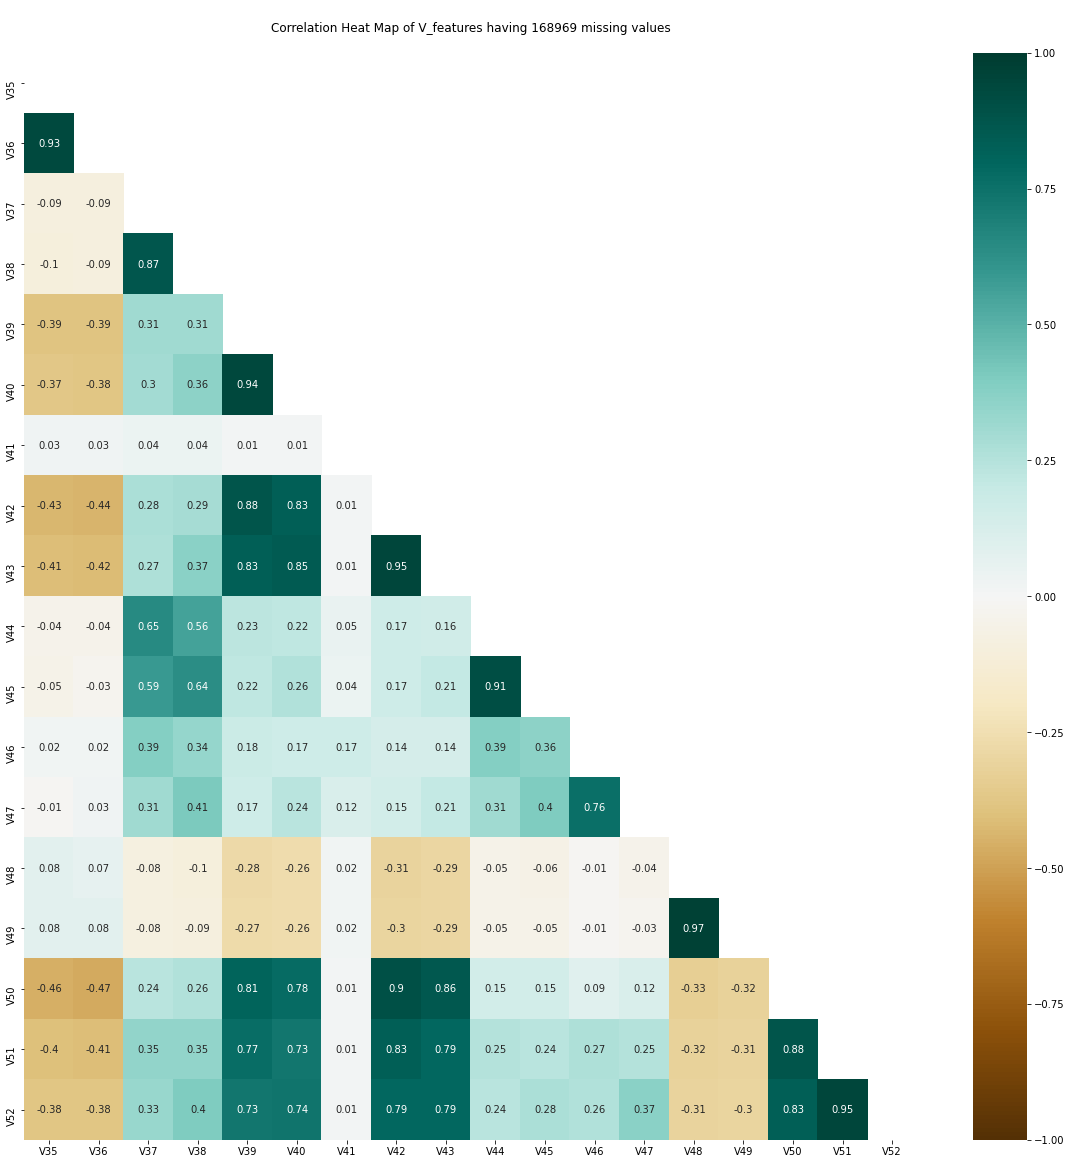

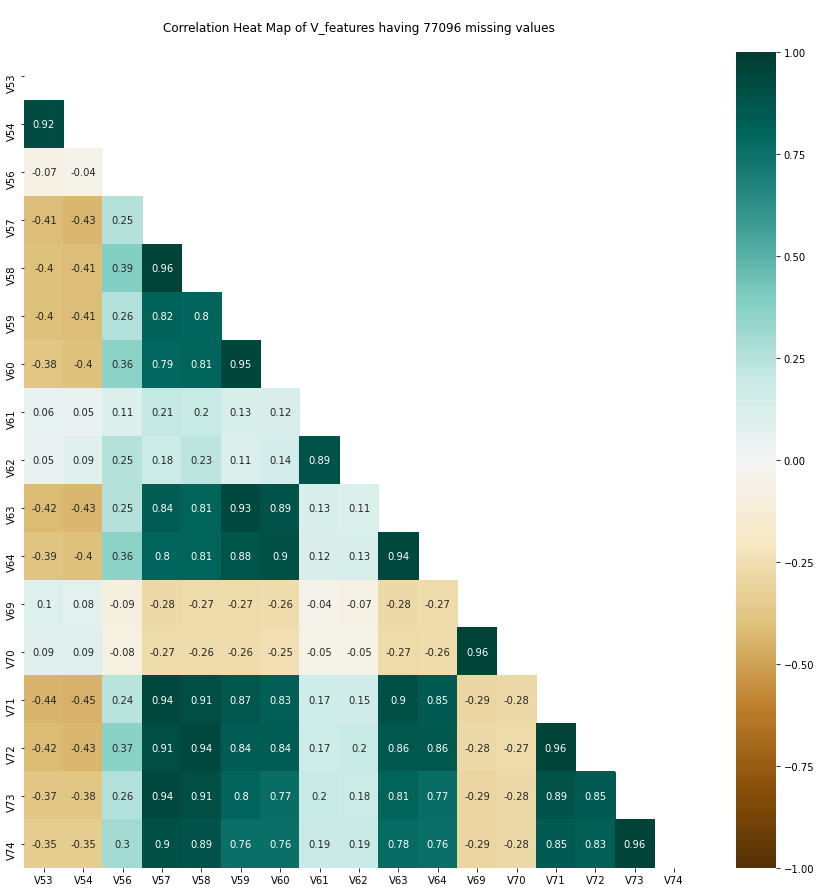

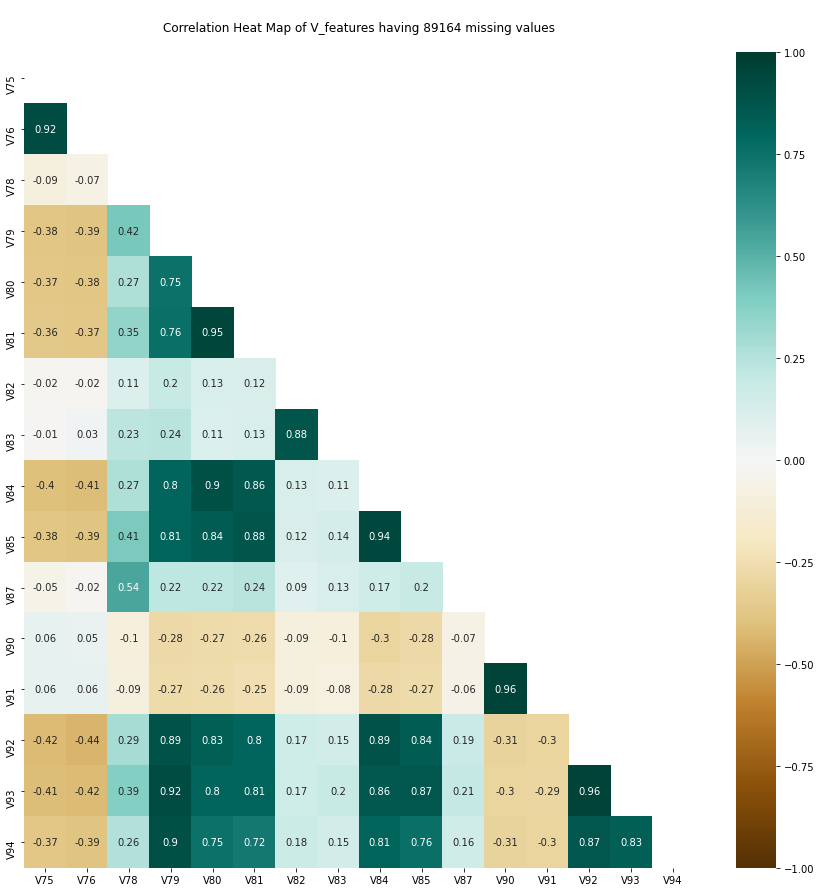

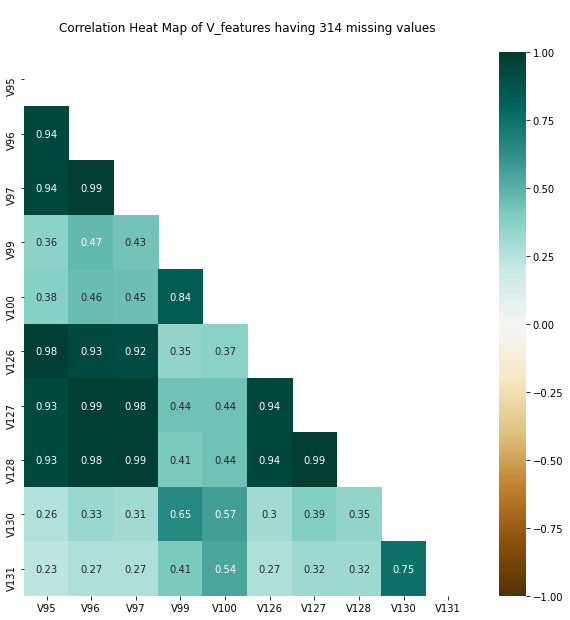

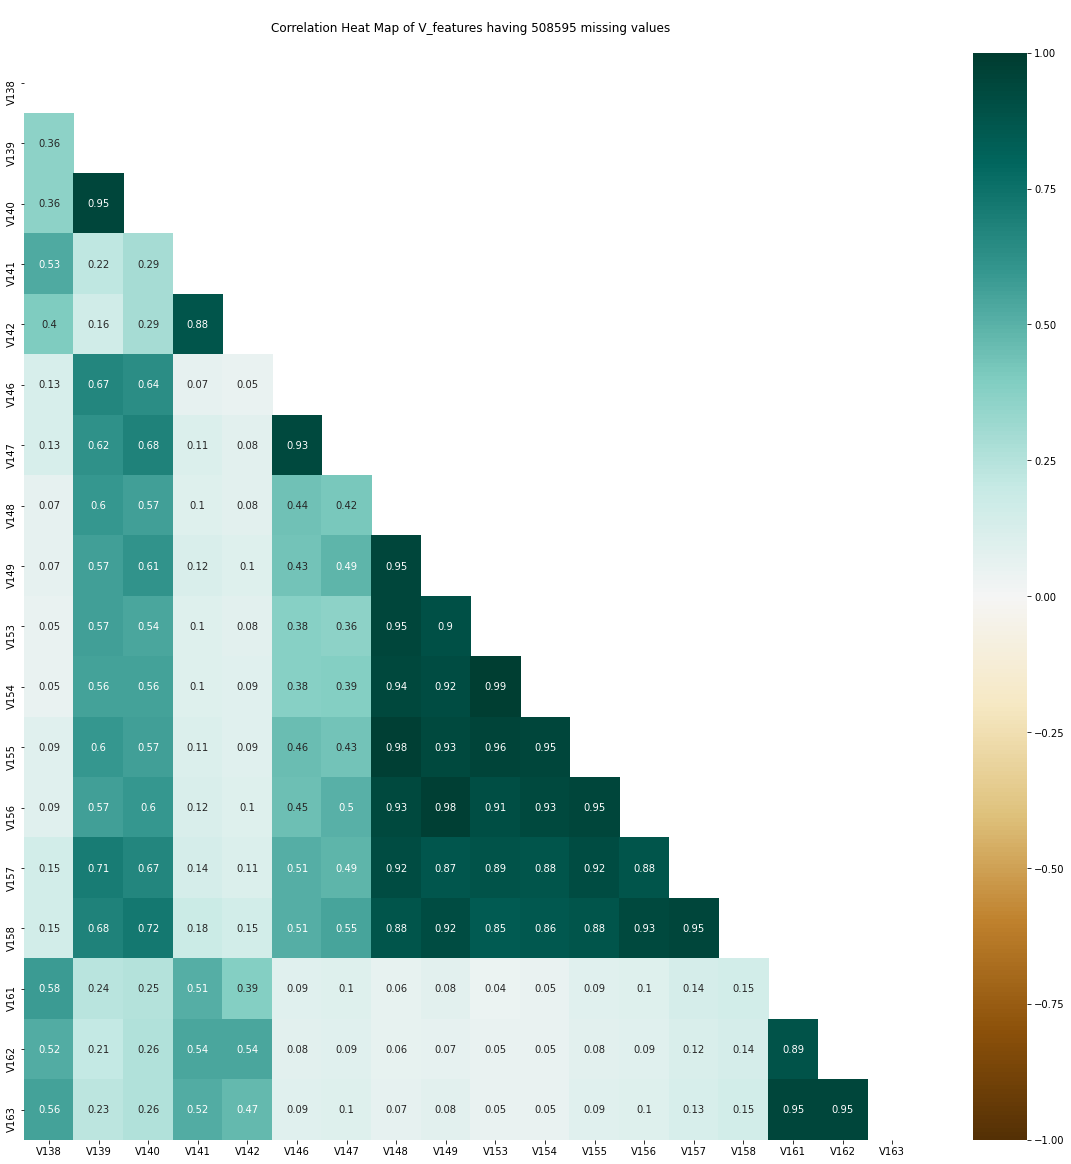

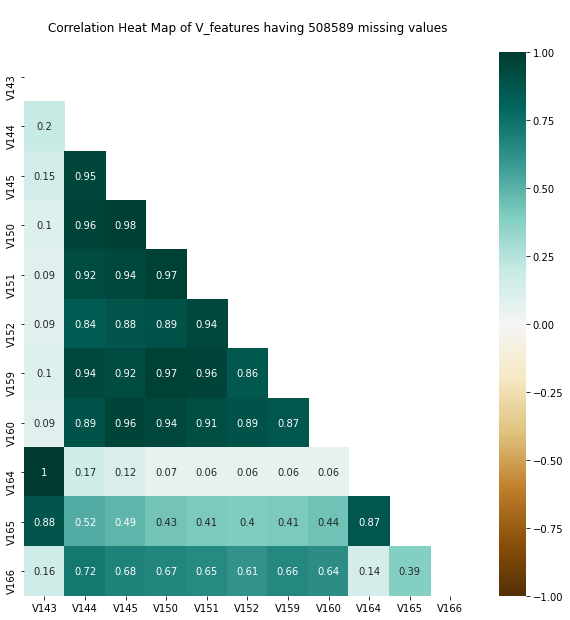

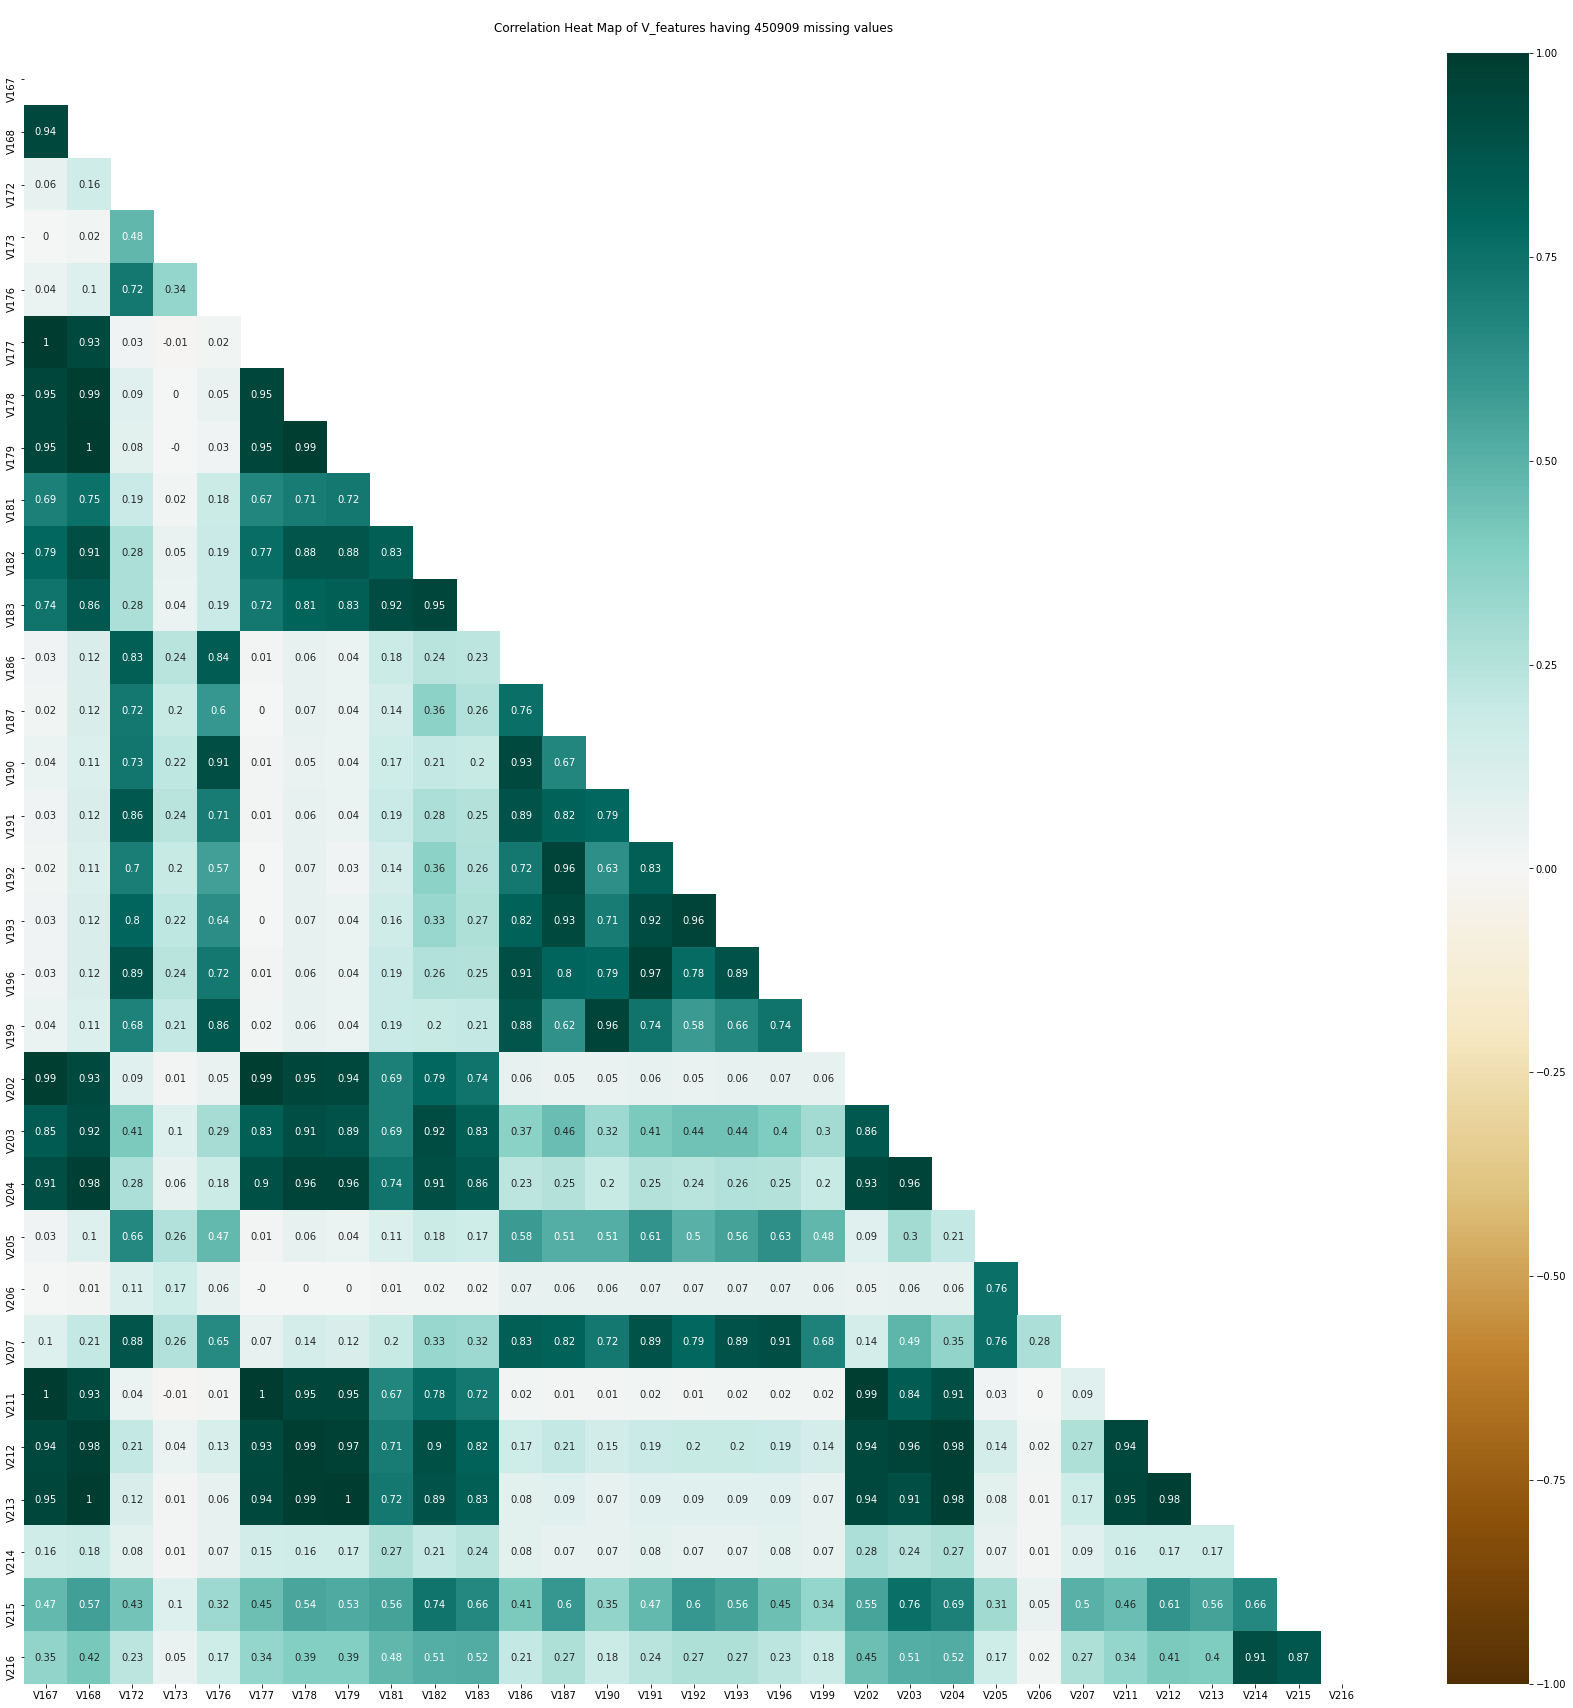

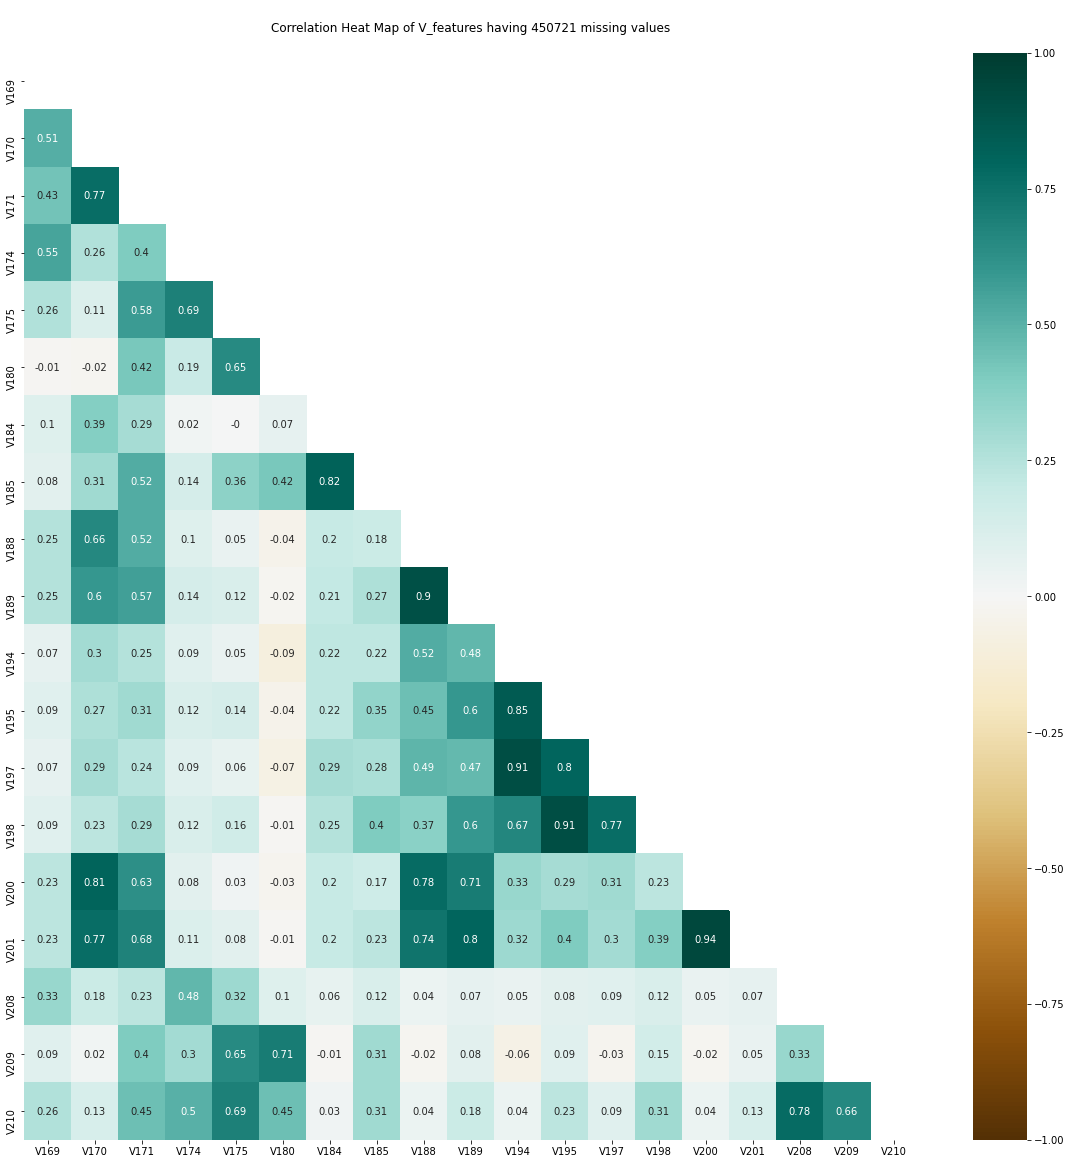

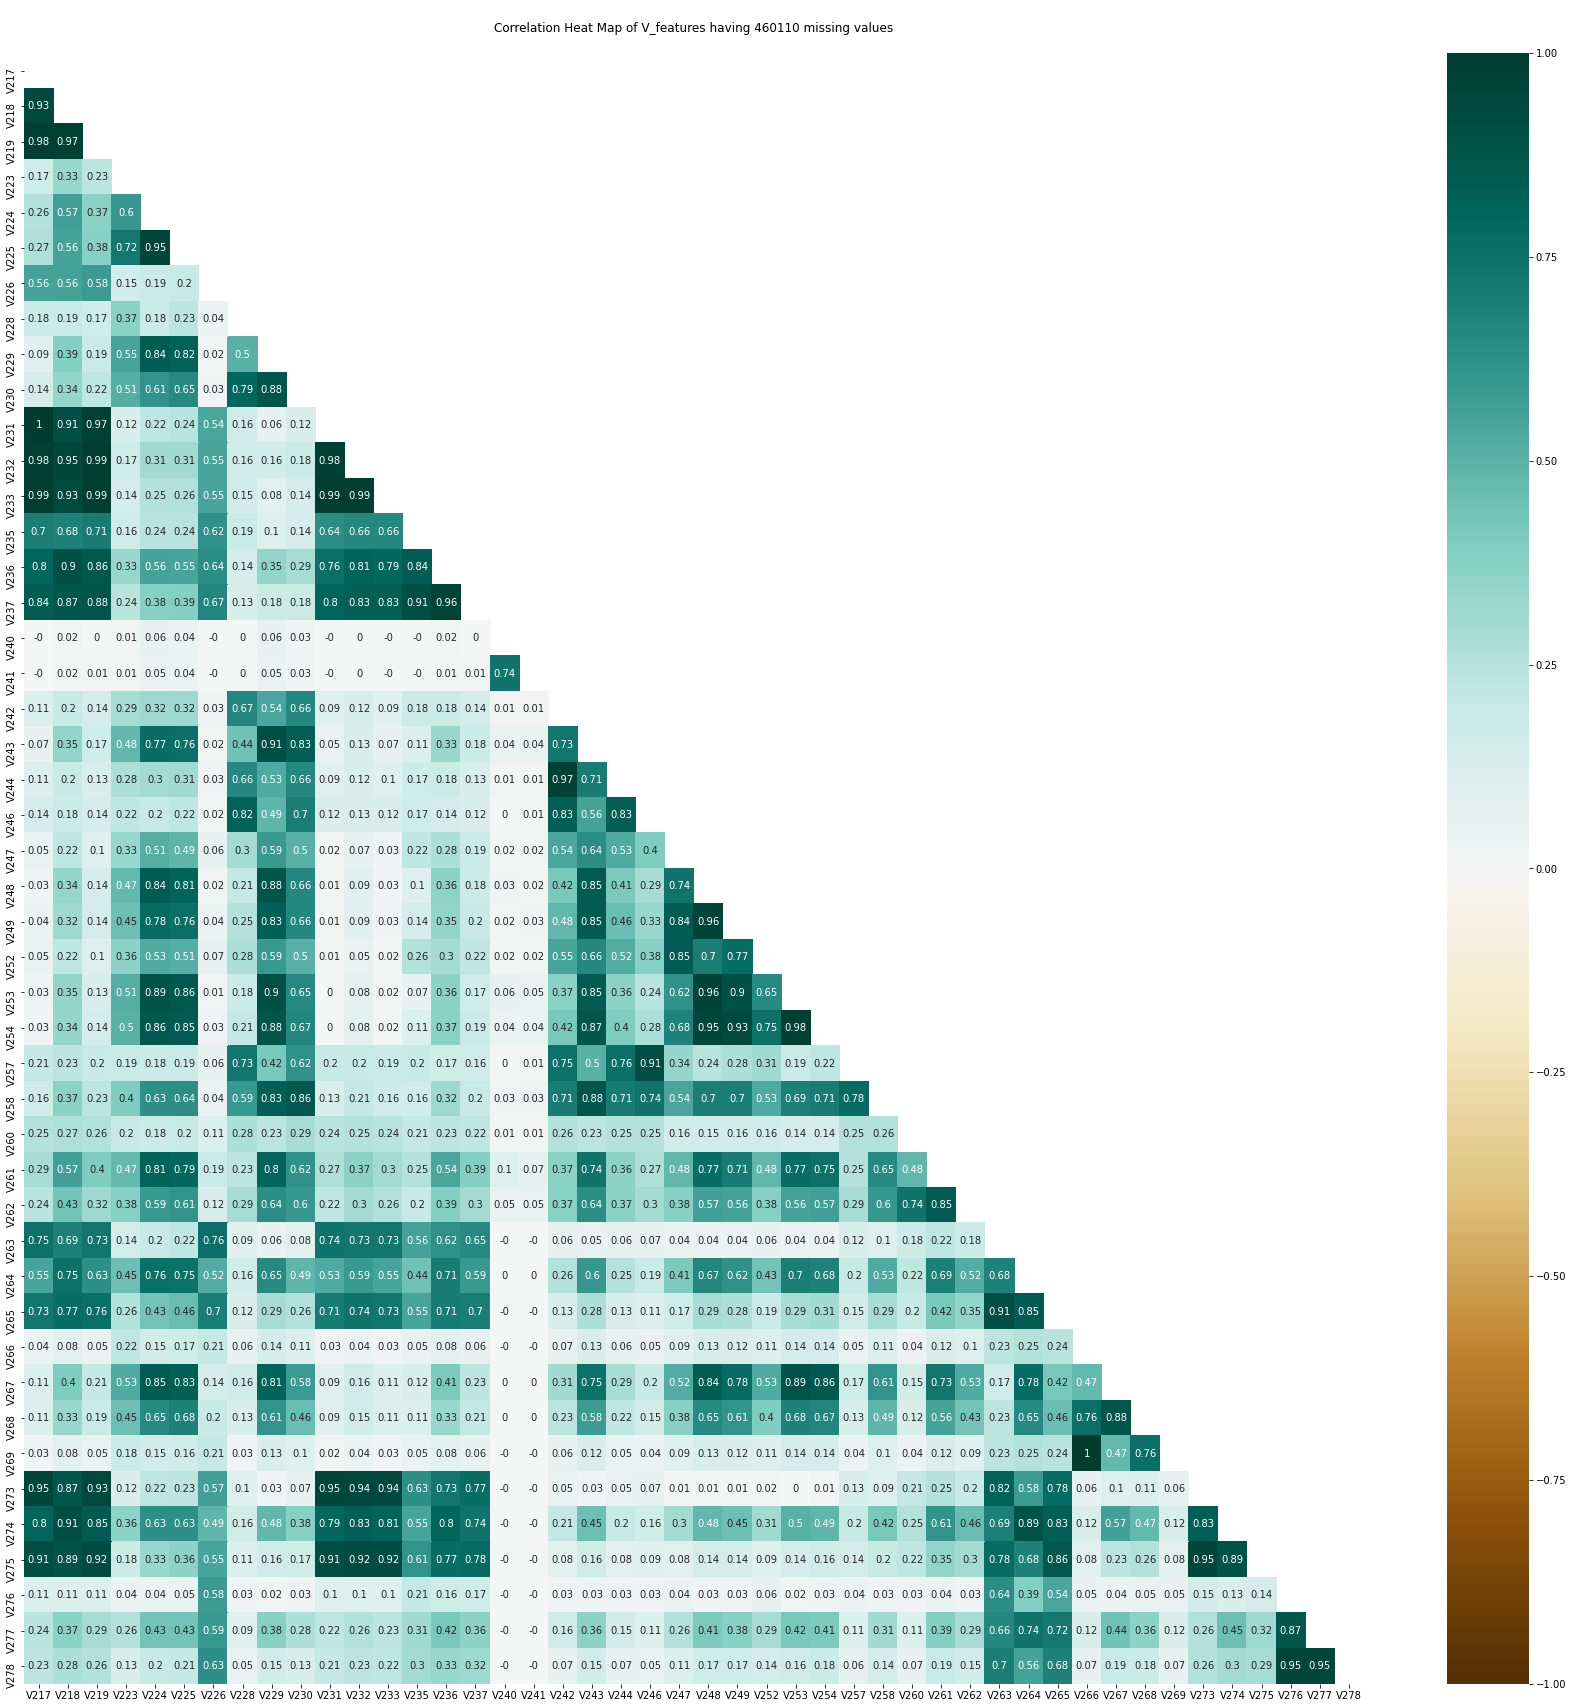

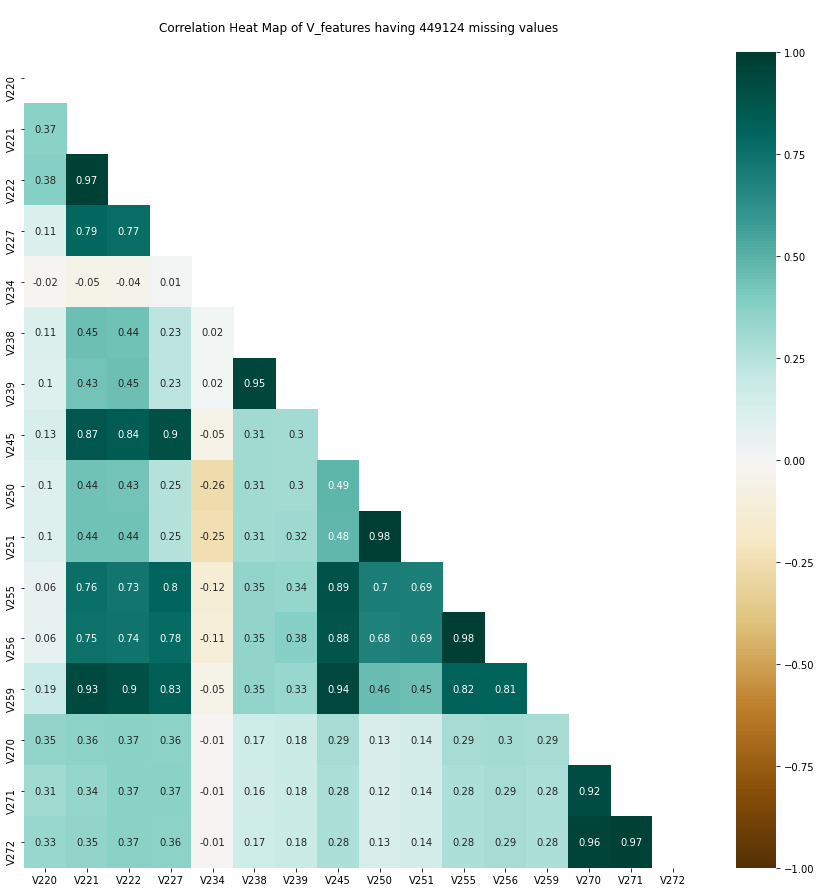

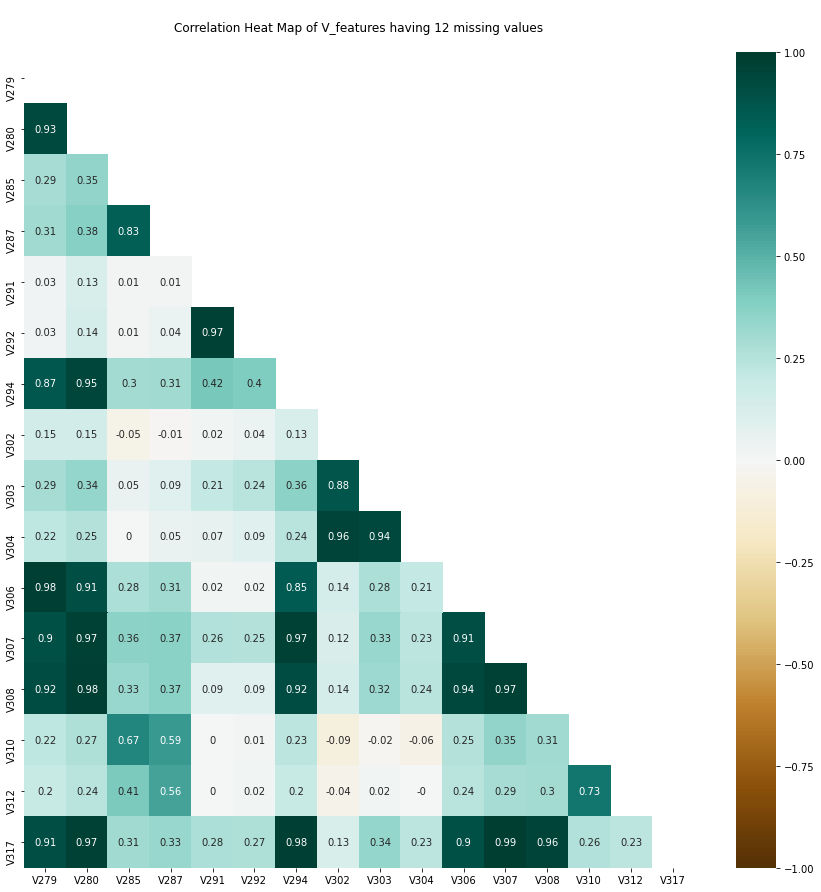

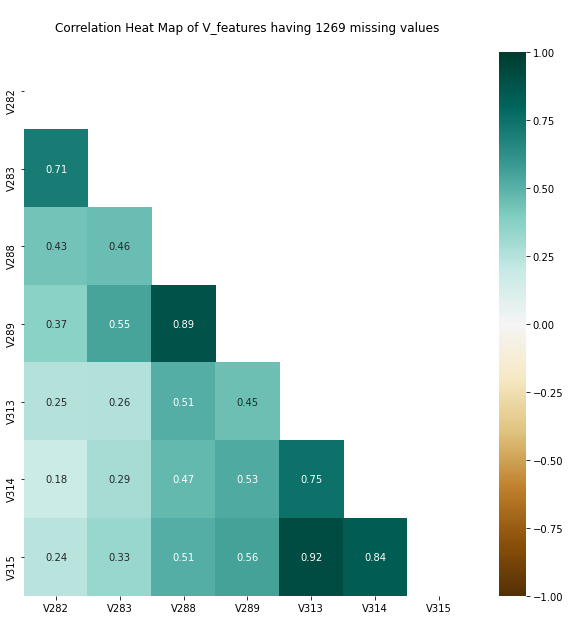

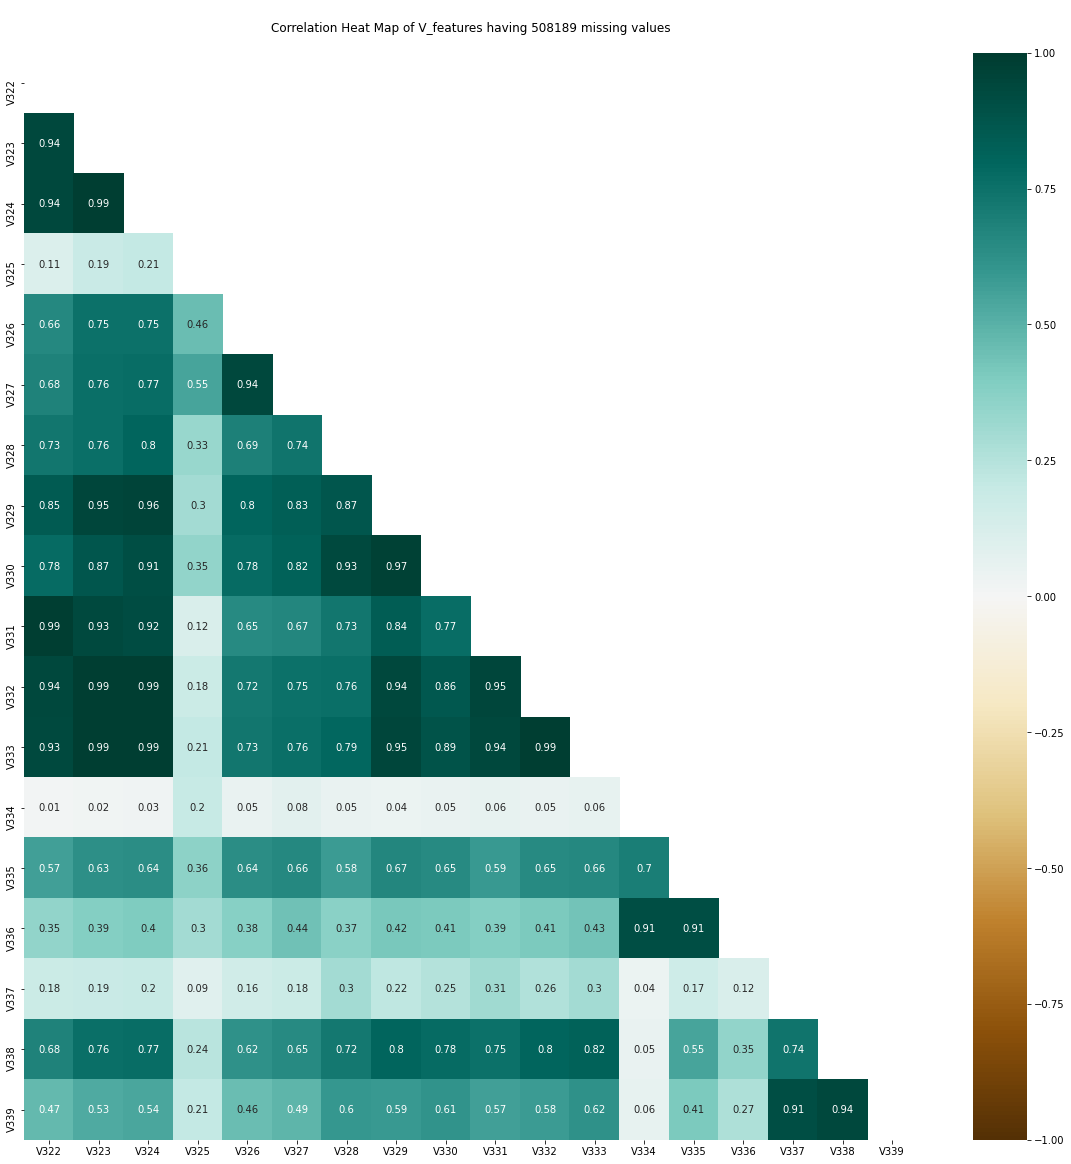

In [31]:
# Now we will be checking for correlation between the feature in the same group

for missing_count, grp in v_grps.items():
    size = (8,8)
    
    if(len(grp)<=12):
        size=(10,10)
    elif(len(grp)<=17):
        size=(15,15)
    elif(len(grp)<=22):
        size=(20,20)
    elif(len(grp)<=27):
        size=(25,25)
    else:
        size=(30,30)
        
    mask = np.triu(np.ones_like(train_data[grp].corr(), dtype=np.bool))
    plt.figure(figsize=size)
    sns.color_palette("crest", as_cmap=True)
    sns.heatmap(np.round(train_data[grp].corr(), 2), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG');
    plt.title('\nCorrelation Heat Map of V_features having {} missing values\n'.format(missing_count))
    plt.show()

__Observation(s):__

Following Inferences can be made from the above results,

1. There are many correlated features within each group, now we can't compute VIF values for V_features because many of them have missing values and VIF does not work with missing values. One work around for this is to impute all the values using some standard value like -999 but this will create extreme bias and hence biased VIF values will be resulted.


2. We will be trying to reduce the V_features based on the correlation values only. As we can see that features within each group can further be grouped based on the correlation values and hence and then we can use either of the feature from the group as a representation of the whole group.
<br><br>

In [32]:
groups_with_subgroups = []

for missing_count, grp in v_grps.items():

  children = set()
  parent_dict = {parent:copy.deepcopy(children) for parent in grp}
  corr = train_data[grp].corr()
  
  for row in corr.iterrows():
    parent = row[0]
    for child,parent_child_corr in row[1].items():  
      if(parent is not child and parent_child_corr>=0.75):
        parent_dict[parent].add(child)
    
  groups_with_subgroups.append(parent_dict)

In [33]:
visited = {"V"+str(i):False for i in range(1,340) if "V"+str(i) in train_data.columns}
final_grps = []

for grps in groups_with_subgroups:
  
  grp={}

  for parent,children in grps.items():
  
    if(not visited[parent]):
      
      s = set()
      grp[parent] = copy.deepcopy(s)
      for child in children:
      
        if(not visited[child]):
      
          grp[parent].add(child)
          visited[child]=True
      
      visited[parent]=True
  
  final_grps.append(grp)

In [34]:
final_grps

[{'V1': set(),
  'V10': {'V11'},
  'V2': {'V3'},
  'V4': {'V5'},
  'V6': {'V7'},
  'V8': {'V9'}},
 {'V12': {'V13'},
  'V15': {'V16', 'V17', 'V18', 'V21', 'V22', 'V31', 'V32', 'V33', 'V34'},
  'V19': {'V20'},
  'V29': {'V30'}},
 {'V35': {'V36'},
  'V37': {'V38'},
  'V39': {'V40', 'V42', 'V43', 'V50', 'V51'},
  'V41': set(),
  'V44': {'V45'},
  'V46': {'V47'},
  'V48': {'V49'},
  'V52': set()},
 {'V53': {'V54'},
  'V56': set(),
  'V57': {'V58', 'V59', 'V60', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74'},
  'V61': {'V62'},
  'V69': {'V70'}},
 {'V75': {'V76'},
  'V78': set(),
  'V79': {'V81', 'V84', 'V85', 'V92', 'V93', 'V94'},
  'V80': set(),
  'V82': {'V83'},
  'V87': set(),
  'V90': {'V91'}},
 {'V130': set(),
  'V131': set(),
  'V95': {'V126', 'V127', 'V128', 'V96', 'V97'},
  'V99': {'V100'}},
 {'V138': set(),
  'V139': {'V140'},
  'V141': {'V142'},
  'V146': {'V147'},
  'V148': {'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158'},
  'V161': {'V162', 'V163'}},
 {'V143': {'V164', 'V165'}

In [35]:
# Above results give us the subgroups within the groups, now from these subgroups we will choose only that feature which has the most unique value since it holds the maximum information

chosen_v_features = []

for grps in final_grps:
  chosen_v_features+=reduce_group(grps)

Use these ['V1', 'V3', 'V4', 'V6', 'V8', 'V11']
Use these ['V13', 'V17', 'V20', 'V30']
Use these ['V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V52']
Use these ['V54', 'V56', 'V60', 'V62', 'V70']
Use these ['V76', 'V78', 'V81', 'V80', 'V82', 'V87', 'V91']
Use these ['V127', 'V99', 'V130', 'V131']
Use these ['V138', 'V139', 'V142', 'V147', 'V156', 'V162']
Use these ['V165', 'V160', 'V166']
Use these ['V203', 'V207', 'V173', 'V176', 'V183', 'V187', 'V205', 'V216', 'V215']
Use these ['V169', 'V171', 'V174', 'V175', 'V180', 'V185', 'V188', 'V195', 'V198', 'V210', 'V209']
Use these ['V274', 'V223', 'V264', 'V263', 'V230', 'V235', 'V240', 'V241', 'V257', 'V252', 'V258', 'V260', 'V262', 'V265', 'V268', 'V277']
Use these ['V220', 'V221', 'V234', 'V238', 'V250', 'V256', 'V271']
Use these ['V307', 'V285', 'V291', 'V303', 'V310', 'V312']
Use these ['V282', 'V283', 'V289', 'V315', 'V314']
Use these ['V332', 'V325', 'V326', 'V328', 'V336', 'V335', 'V339', 'V338']


In [36]:
# Chosen V_features

print(chosen_v_features)

['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V17', 'V20', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V52', 'V54', 'V56', 'V60', 'V62', 'V70', 'V76', 'V78', 'V81', 'V80', 'V82', 'V87', 'V91', 'V127', 'V99', 'V130', 'V131', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V203', 'V207', 'V173', 'V176', 'V183', 'V187', 'V205', 'V216', 'V215', 'V169', 'V171', 'V174', 'V175', 'V180', 'V185', 'V188', 'V195', 'V198', 'V210', 'V209', 'V274', 'V223', 'V264', 'V263', 'V230', 'V235', 'V240', 'V241', 'V257', 'V252', 'V258', 'V260', 'V262', 'V265', 'V268', 'V277', 'V220', 'V221', 'V234', 'V238', 'V250', 'V256', 'V271', 'V307', 'V285', 'V291', 'V303', 'V310', 'V312', 'V282', 'V283', 'V289', 'V315', 'V314', 'V332', 'V325', 'V326', 'V328', 'V336', 'V335', 'V339', 'V338']


In [37]:
plt.figure(figsize=(40,40))
sns.color_palette("crest", as_cmap=True)
sns.heatmap(np.round(train_data[chosen_v_features].corr(), 2), vmin=-1, vmax=1, annot=True, cmap='BrBG');
plt.title('\nCorrelation Heat Map of remaining V_features\n'.format(missing_count))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

__Observation(s):__

Following Inferences can be made from the above results,

1. Even now we have some of the features which are correlated but we won't be removing any further since we do not want to loose the information regarding the missing values of each group.
<br><br>

In [38]:
not_chosen_v_fetaures = [f for f in v_features if f not in chosen_v_features]

In [39]:
train_data.drop(not_chosen_v_fetaures, axis=1, inplace=True)
test_data.drop(not_chosen_v_fetaures, axis=1, inplace=True)

## Checking for Consistency of Features over Time
<br>

To perform this we will be training a simple XGBoost model using one feature at a time. We will be using the first 20% data to train the model and we will be predicting the last 20% dataset using this model. If we get both training and test AUC to be greater than 0.5. Then we keep the feature else we remove it.
<br><br>

In [40]:
features_auc={}

cols = list(train_data.columns)
cols.remove('isFraud')

for f in cols:
    train_auc, cv_auc = is_consistent_over_time(train_data, f)
    features_auc[f] = {'train_auc':train_auc, 'cv_auc':cv_auc}

In [41]:
features_auc

{'C1': {'cv_auc': 0.6089773473258145, 'train_auc': 0.6910159628502225},
 'C10': {'cv_auc': 0.5691609692553392, 'train_auc': 0.6640595209632287},
 'C11': {'cv_auc': 0.5921743156806173, 'train_auc': 0.6822830051390768},
 'C12': {'cv_auc': 0.6828144929885468, 'train_auc': 0.6528652720791146},
 'C13': {'cv_auc': 0.6081393309188993, 'train_auc': 0.7025666225924617},
 'C14': {'cv_auc': 0.6129804688244378, 'train_auc': 0.6614368651226318},
 'C2': {'cv_auc': 0.6236041668766745, 'train_auc': 0.7032232511401042},
 'C4': {'cv_auc': 0.6935239249331726, 'train_auc': 0.6465194573857247},
 'C5': {'cv_auc': 0.6404635165764865, 'train_auc': 0.6042152451958999},
 'C6': {'cv_auc': 0.5664866222202675, 'train_auc': 0.662202184340531},
 'C7': {'cv_auc': 0.6596667757240127, 'train_auc': 0.6517654228684655},
 'C9': {'cv_auc': 0.6745360291593494, 'train_auc': 0.5775175107391969},
 'D1': {'cv_auc': 0.603813298671227, 'train_auc': 0.6504004954993099},
 'D10': {'cv_auc': 0.6227381629728077, 'train_auc': 0.6563452

In [42]:
# Time Inconsistent features having train or test auc less than 0.5

time_inconsistent_features = [f for f, auc in features_auc.items() if auc['cv_auc']<0.5]

In [43]:
# Following Features are time incosistent and hence we will be removing them from the dataset

print(time_inconsistent_features)

['card4', 'V41', 'V56', 'V62', 'V138', 'V142', 'V160', 'V162', 'V187', 'V188', 'V256', 'V285', 'V314', 'V325', 'V326', 'V328', 'V332', 'V335', 'V336', 'V338', 'V339', 'id_14', 'id_31', 'id_32', 'id_34', 'id_38']


In [44]:
train_data.drop(time_inconsistent_features, axis=1, inplace=True)
test_data.drop(time_inconsistent_features, axis=1, inplace=True)

In [45]:
# Train and Test Dataset Shape after performing basic Data Cleaning

print("*"*35)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*35)

***********************************

 Train Data Shape : (590540, 160) 


 Test Data Shape : (506691, 159) 

***********************************


In [46]:
# Saving the Cleaned Datasets

train_data.to_pickle('basic_clean_train.pkl')
test_data.to_pickle('basic_clean_test.pkl')